In [1]:
# so kernel doesn't have to be restarted
%load_ext autoreload
%autoreload 2

In [2]:
# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# data science imports
import numpy as np
import matplotlib.pyplot as plt

# helper scripts
from knn_helper import *

# handle DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# set seed
np.random.seed(42)
# generate 1000x10 multivariate normal data with identity covariance matrix
X = np.random.multivariate_normal(mean=np.zeros(10), cov=np.eye(10), size=2000)
# create ground-truth feature importance labels
true_importance = np.array([5, 4, 3, 2, 1, 0, 0, 0, 0, 0])
# create binary target variable based on a linear combination of the features
y = (X @ true_importance + np.random.normal(0, 0.1, size=2000) > 0).astype(int)

In [4]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# get predictions and calculate accuracy
y_pred = log_reg.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.9875


In [5]:
# get beta coefficients
beta_coefficients = log_reg.coef_[0]
print("Beta Coefficients:", beta_coefficients)

Beta Coefficients: [ 6.62100507e+00  5.15120541e+00  4.07631302e+00  2.76430649e+00
  1.40033604e+00 -5.32692752e-02 -3.88225928e-03  5.98098407e-03
  1.53141564e-02  2.49543946e-03]


In [6]:
# set parameters
k = 1 # looking for the nearest neighbor
nbr_dist = "l1" # distance to use to find nearest neighbor
cfact_dist = "l1" # distance to use to evaluate counterfactuals
use_preds = True # do we use y_hat or y?

In [7]:
# set seed
np.random.seed(42)

# get and split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print("Data Retrieved")

# get fit models
rf, rf_plus, rf_plus_no_raw = fit_models(X_train, y_train)

mdi_vals = rf.feature_importances_

if use_preds:
    rf_y_test, rf_plus_y_test, rf_plus_no_raw_y_test = \
        get_predictions(X_test, rf, rf_plus, rf_plus_no_raw)

print("Models Fit")

Data Retrieved


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


Models Fit


In [8]:
# get raw data
raw_train = X_train
raw_test = X_test

# get shap
shap_train = get_shap(X_train, rf)
shap_test = get_shap(X_test, rf)

# get lime
lime_train = get_lime(X_train, rf)
lime_test = get_lime(X_test, rf)

# get lmdi values
lmdi_train = get_lmdi(X_train, y_train, rf_plus)
if use_preds:
    lmdi_test = get_lmdi(X_test, rf_plus_y_test, rf_plus)
else:
    lmdi_test = get_lmdi(X_test, y_test, rf_plus)

print("LFI Values Retrieved")


LFI Values Retrieved


In [9]:
if use_preds:
    raw_opposite = get_k_opposite_neighbors(k, nbr_dist, raw_train, raw_test, y_train, rf_y_test)
    shap_opposite = get_k_opposite_neighbors(k, nbr_dist, shap_train, shap_test, y_train, rf_y_test)
    lime_opposite = get_k_opposite_neighbors(k, nbr_dist, lime_train, lime_test, y_train, rf_y_test)
    lmdi_opposite = get_k_opposite_neighbors(k, nbr_dist, lmdi_train, lmdi_test, y_train, rf_plus_y_test)
else:
    raw_opposite = get_k_opposite_neighbors(k, nbr_dist, raw_train, raw_test, y_train, y_test)
    shap_opposite = get_k_opposite_neighbors(k, nbr_dist, shap_train, shap_test, y_train, y_test)
    lime_opposite = get_k_opposite_neighbors(k, nbr_dist, lime_train, lime_test, y_train, y_test)
    lmdi_opposite = get_k_opposite_neighbors(k, nbr_dist, lmdi_train, lmdi_test, y_train, y_test)

print(f"Opposite Neighbors Found Using '{nbr_dist}' Distance")

raw_distances = get_coord_nbr_dist(k, raw_opposite, X_train, X_test)
shap_distances = get_coord_nbr_dist(k, shap_opposite, X_train, X_test)
lime_distances = get_coord_nbr_dist(k, lime_opposite, X_train, X_test)
lmdi_distances = get_coord_nbr_dist(k, lmdi_opposite, X_train, X_test)

print(f"Average Distances Calculated")

Opposite Neighbors Found Using 'l1' Distance
Average Distances Calculated


In [10]:
# outcomes
shap_vals = np.abs(shap_test)
lime_vals = np.abs(lime_test)
lmdi_vals = np.abs(lmdi_test)

In [11]:
# get means
shap_avg = np.mean(shap_vals, axis=0)
lime_avg = np.mean(lime_vals, axis=0)
lmdi_avg = np.mean(lmdi_vals, axis=0)

# get medians
shap_median = np.median(shap_vals, axis=0)
lime_median = np.median(lime_vals, axis=0)
lmdi_median = np.median(lmdi_vals, axis=0)

# get variances
shap_var = np.var(shap_vals, axis=0)
lime_var = np.var(lime_vals, axis=0)
lmdi_var = np.var(lmdi_vals, axis=0)

In [12]:
# get mean distances to counterfactuals
raw_dist_avg = np.mean(raw_distances, axis=0)
shap_dist_avg = np.mean(shap_distances, axis=0)
lime_dist_avg = np.mean(lime_distances, axis=0)
lmdi_dist_avg = np.mean(lmdi_distances, axis=0)

# get median distances to counterfactuals
raw_dist_median = np.median(raw_distances, axis=0)
shap_dist_median = np.median(shap_distances, axis=0)
lime_dist_median = np.median(lime_distances, axis=0)
lmdi_dist_median = np.median(lmdi_distances, axis=0)

# get variance distances to counterfactuals
raw_dist_var = np.var(raw_distances, axis=0)
shap_dist_var = np.var(shap_distances, axis=0)
lime_dist_var = np.var(lime_distances, axis=0)
lmdi_dist_var = np.var(lmdi_distances, axis=0)

In [13]:
lfi_tensor = np.array([shap_vals, lime_vals, lmdi_vals])
distance_tensor = np.array([raw_distances, shap_distances, lime_distances, lmdi_distances])

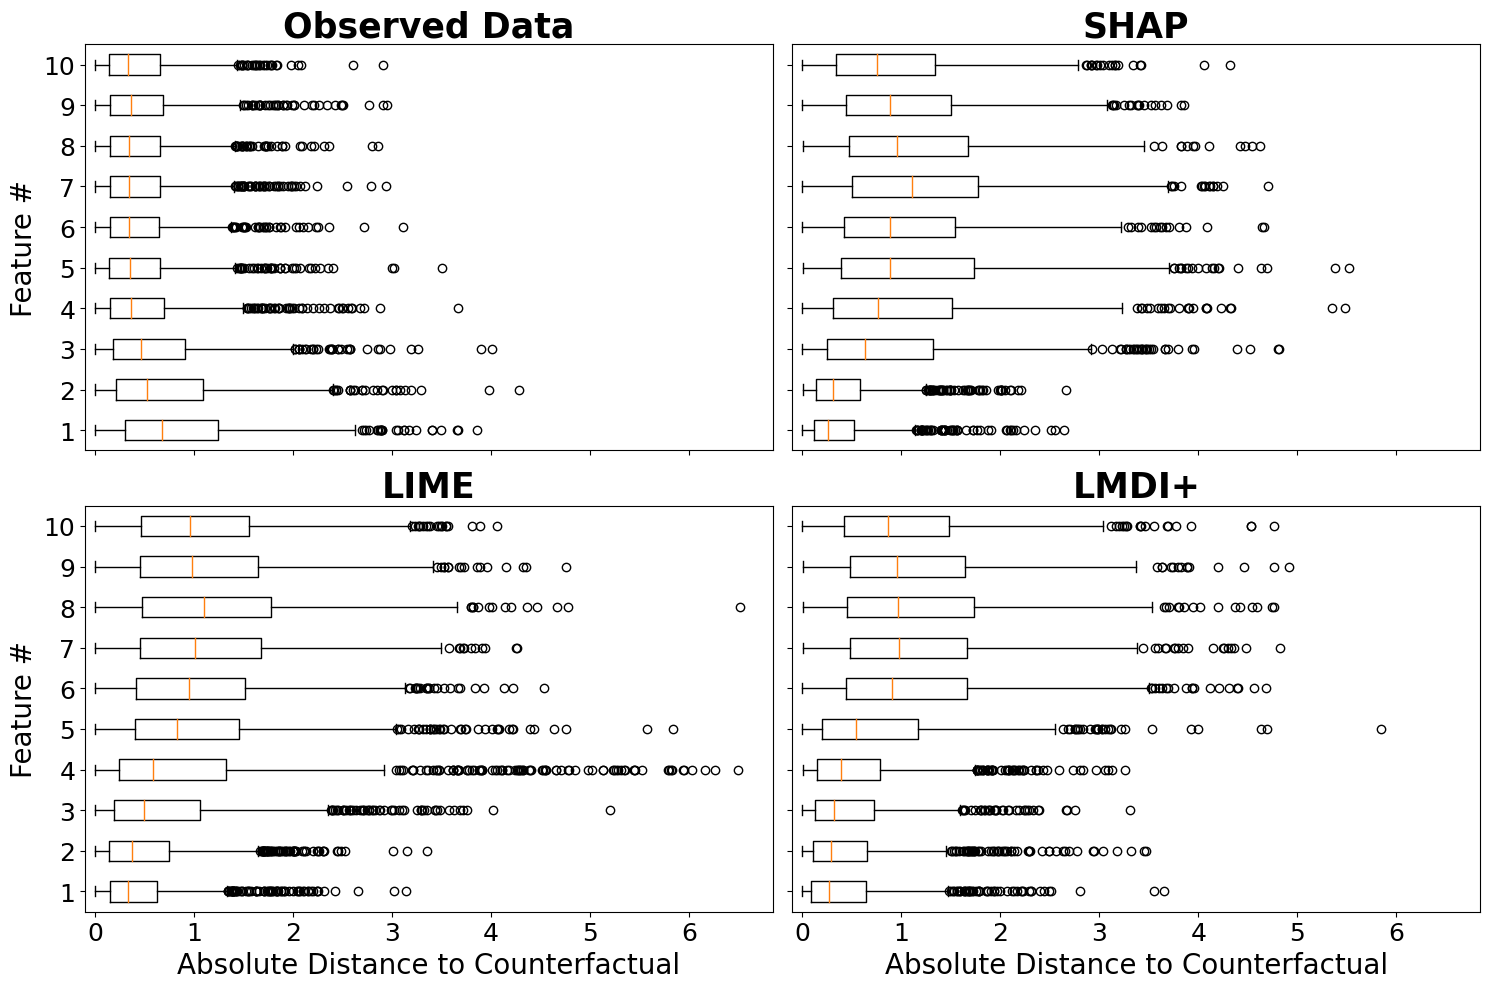

In [14]:
### PLOT DISTANCE TO COUNTERFACTUALS ###

methods = ['Observed Data', 'SHAP', 'LIME', 'LMDI+']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, method in enumerate(methods):
    # set axis tick font to be bigger
    axes[i].tick_params(axis='both', which='major', labelsize=18)
    # set axis title font to be bigger
    axes[i].set_title(method, fontsize=25, fontweight='bold')
    # set axis label font to be bigger
    axes[i].boxplot(distance_tensor[i], vert=False)
    # axes[i].set_title(method)
    axes[i].set_xlabel('Absolute Distance to Counterfactual', fontsize=20)
    axes[i].set_yticks(range(1, distance_tensor[i].shape[1] + 1))
    axes[i].set_ylabel('Feature #', fontsize=20)
    axes[i].set_yticklabels([f'{j+1}' for j in range(distance_tensor[i].shape[1])])
    axes[i].set_xlim(-0.1, np.max(distance_tensor) * 1.05)
    # take away x-axis tick labels for the top row
    if i < 2:
        axes[i].set_xticklabels([])
    # take away y-axis tick labels for the right column
    if i % 2 == 1:
        axes[i].set_yticklabels([])
    # take away x-axis label for the top row
    if i < 2:
        axes[i].set_xlabel('')
    # take away y-axis label for the right column
    if i % 2 == 1:
        axes[i].set_ylabel('')
plt.tight_layout()
# plt.savefig('images/cfact_simulation.pdf', bbox_inches='tight', format='pdf')
plt.show()